In [2]:
# Import packages for working with files and folders
import os
import pathlib

# Import package for working with geospatial vector data
import geopandas as gpd

# Import package for working with tabular data
import pandas as pd

import matplotlib.pyplot as plt

# Import tool for timing functions
import time

# Import tool to extract csv from GBIF zipfiles
import zipfile

# Allows for secure input of GBIF password
from getpass import getpass

# Import tool for fiding files by pattern
from glob import glob

# Import tool for HTTP request - authenticate GBIF account to download data
import requests

# Import package for working with geospatial vector data
import geopandas as gpd

# Import package for working with tabular data
import pandas as pd

# Import tools for dowloading species occurrence data from GBIF
import pygbif.occurrences as occ

# Import tools for looking up species names and info
import pygbif.species as species

### Define Study Area - Load Elwha River Watershed 

In [17]:
# Define project data folder
data_dir = r"C:\Users\nymve\Documents\education\earth-data-analytics\fall-2025\data\WBD_17_HU2_GPKG"

# Make sure the folder exists
os.makedirs(data_dir, exist_ok=True)

# Path to your downloaded GeoPackage
wbd_gpkg_path = os.path.join(data_dir, "WBD_17_HU2_GPKG.gpkg")

# === 3. Load the HUC12 layer ===
wbd_gdf = gpd.read_file(wbd_gpkg_path, layer="WBDHU12")

# Optional: inspect columns and first few rows
print(wbd_gdf.columns)

# Quick look at the first 5 rows
print(wbd_gdf.head())

Index(['tnmid', 'metasourceid', 'sourcedatadesc', 'sourceoriginator',
       'sourcefeatureid', 'loaddate', 'referencegnis_ids', 'areaacres',
       'areasqkm', 'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc',
       'noncontributingareaacres', 'noncontributingareasqkm', 'shape_Length',
       'shape_Area', 'hutype_description', 'geometry'],
      dtype='object')
                                    tnmid  \
0  {0E4E6573-8B28-4F8C-B959-694DE3A9F91C}   
1  {07FD06B3-4536-4B3D-A598-8D646D308101}   
2  {8720D0B0-BEF6-492F-B878-1B0343DB67DD}   
3  {F673354E-0002-4C26-8E80-CFA9C84F31AA}   
4  {546E09D7-5785-4B5B-A284-634E682D7C41}   

                             metasourceid                    sourcedatadesc  \
0  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
1  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
2  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
3  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}

<Axes: >

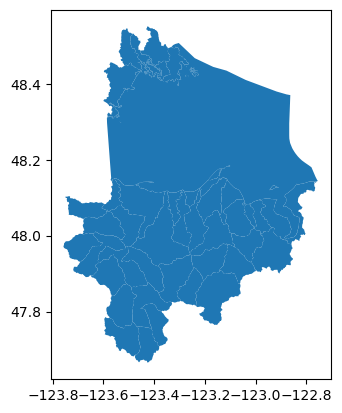

In [ ]:
# Filter HUC12s in Elwha HUC8
elwha_gdf = wbd_gdf[wbd_gdf['huc12'].str.startswith("17110020")]

# Rename columns
elwha_gdf = elwha_gdf[['name', 'huc12', 'geometry']].rename(columns={'huc12':'huc'}).set_index('huc')

# Plot the watershed to check data
elwha_gdf.plot()

In [19]:
print(len(elwha_gdf))

39


In [20]:
# Print the names of the selected HUC12s
print(elwha_gdf['name'])

huc
171100200604             Mill Stream-Frontal Esquimalt Harbour
171100200601                  Bowker Creek-Frontal Haro Strait
171100200401                                    McDonald Creek
171100200307                             Lower Dungeness River
171100200102               Beckett Point-Frontal Discovery Bay
171100200403                                       Morse Creek
171100200402                                     Siebert Creek
171100200405           Ennis Creek-Frontal Port Angeles Harbor
171100200603        Craigflower Creek-Frontal Victoria Harbour
171100200103                 Eagle Creek-Frontal Discovery Bay
171100200201                             Jimmycomelately Creek
171100200602                                    Colquitz River
171100200514                          Lake Aldwell-Elwha River
171100200101                Salmon Creek-Frontal Discovery Bay
171100200513                                      Indian Creek
171100200512                          Hughes Creek-

In [23]:
elwha_gdf.head()

,name,geometry
huc,,
171100200514,Lake Aldwell-Elwha River,"POLYGON ((-123.5546 48.14748, -123.55447 48.14..."
171100200512,Hughes Creek-Elwha River,"POLYGON ((-123.58878 48.06277, -123.58871 48.0..."
171100200501,Headwaters Elwha River,"POLYGON ((-123.5761 47.78401, -123.57564 47.78..."
171100200502,Godkin Creek,"POLYGON ((-123.41198 47.75662, -123.41161 47.7..."
171100200505,Lost River-Elwha River,"POLYGON ((-123.42329 47.87604, -123.42215 47.8..."


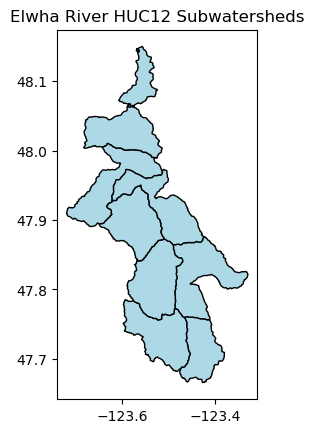

In [24]:
# Filter Elwha HUC12 subwatershed within HUC8 Dungeness-Elwha watershed
elwha_huc12s = [
    "171100200501",
    "171100200502",
    "171100200504",
    "171100200505",
    "171100200507",
    "171100200508",
    "171100200510",
    "171100200512",
    "171100200514",
]

# Create geodataframe and filter for the Elwha HUC12s
elwha_gdf = wbd_gdf[wbd_gdf['huc12'].isin(elwha_huc12s)]

# Select relevant columns and set index
elwha_gdf = elwha_gdf[['name', 'huc12', 'geometry']].rename(columns={'huc12':'huc'}).set_index('huc')

# Plot to check data
elwha_gdf.plot(edgecolor='black', facecolor='lightblue')
plt.title("Elwha River HUC12 Subwatersheds")
plt.show()

### Load GBIF Data for Salmon

In [5]:
# Create data directory
coho_salmon_dir = os.path.join(

    # Home directory
    pathlib.Path.home(),

    # Earth analytics data directory
    'earth-analytics',
    'data',
    
    # Project directory
    'coho-salmon-directory')

### Make the directory
os.makedirs(coho_salmon_dir, exist_ok = True)

### Define directory name for gbif data
gbif_dir = os.path.join(coho_salmon_dir, 'gbif')

### Make the directory
os.makedirs(gbif_dir, exist_ok = True)

In [6]:
####--------------------------####
#### DO NOT MODIFY THIS CODE! ####
####--------------------------####
# This code ASKS for your credentials 
# and saves it for the rest of the session.
# NEVER put your credentials into your code!!!!

# GBIF needs a username, password, and email 
# All 3 need to match the account
reset = False

# Request and store username
if (not ('GBIF_USER'  in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')
    
# Request and store account email address
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

In [7]:
'GBIF_PWD' in os.environ

True

In [8]:
### Grab the species info
backbone = species.name_backbone(name= 'Oncorhynchus kisutch')

### Look at the species info
backbone

{'usageKey': 5204034,
 'scientificName': 'Oncorhynchus kisutch (Walbaum, 1792)',
 'canonicalName': 'Oncorhynchus kisutch',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Salmoniformes',
 'family': 'Salmonidae',
 'genus': 'Oncorhynchus',
 'species': 'Oncorhynchus kisutch',
 'kingdomKey': 1,
 'phylumKey': 44,
 'orderKey': 1313,
 'familyKey': 8615,
 'genusKey': 2351426,
 'speciesKey': 5204034}

In [9]:
### Pull out the species key
species_key = backbone['usageKey']

### Look at species key
species_key

5204034

In [10]:
# Only download once
### Set file name for download
gbif_pattern = os.path.join(coho_salmon_dir, '*.csv')

### Double check that there isn't already a file that matches this pattern.
### If it already exists, skip the whole conditional
### And go straight to the line: gbif_path = glob(gbif_pattern)[0]
if not glob(gbif_pattern):

    ### Only submit a download request to GBIF once
    ### If GBIF_DOWNLOAD_KEY is not defined in our environment, make the download request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:

        ### Submit a query to GBIF
        gbif_query = occ.download([

            ### Add your species key here
            f"speciesKey = {5204034}",

            ### Filter out results that are missing coordinates
            "hasCoordinate = True",

            ### Choose a year to include
            "year >= 2000",
            "year <= 2024",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']

    ### Use the occurrence command module in pygbif to get the metadata
    wait = occ.download_meta(download_key)['status']

    ### Check if the status of the download = "SUCCEEDED"
    ### Wait and loop through until it finishes
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']

        ### Don't want to re-query the API in the loop too frequently
        time.sleep(5)

    # Download GBIF data when it's ready
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=coho_salmon_dir)

    # Unzip GBIF data using the zipfile package
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=coho_salmon_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

INFO:Your download key is 0014604-251120083545085
INFO:Download file size: 6337720 bytes
INFO:On disk at C:\Users\nymve\earth-analytics\data\coho-salmon-directory/0014604-251120083545085.zip


In [11]:
# Current path to the CSV file (first match)
gbif_path = glob(gbif_pattern)[0]

# New file name (for example, 'trumpeter_swan_2022.csv')
new_name = os.path.join(coho_salmon_dir, 'coho_salmon_2000_2024.csv')

# Rename the file
# Only rename if the new file doesn't already exist
if os.path.exists(gbif_path) and not os.path.exists(new_name):
    os.rename(gbif_path, new_name)
    gbif_path = new_name

# Update gbif_path to point to the renamed file
gbif_path = new_name

# Check the rename csv file location
print("CSV renamed to:", gbif_path)

CSV renamed to: C:\Users\nymve\earth-analytics\data\coho-salmon-directory\coho_salmon_2000_2024.csv


In [12]:
# Load the GBIF data
# Read the renamed CSV into a DataFrame
salmon_gbif_df = pd.read_csv(
    gbif_path,
    # GBIF files are tab-separated
    delimiter='\t',  
    # Helps avoid dtype warnings for large files 
    low_memory=False, 
    # Set index
    index_col='gbifID', 
    # Select coloumns needed for analysis
    usecols=['gbifID', 'decimalLatitude', 'decimalLongitude', 'month'] #
)

# Display first few rows of the dataframe to check data
salmon_gbif_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
3441442424,50.274475,-125.377945,6.0
5864828211,44.446000,-123.722780,1.0
5864646780,45.703870,-121.504910,6.0
2251566616,48.820000,-125.150000,6.0
3032816314,50.695800,-126.982185,8.0


In [13]:
# Convert GBIF dataframe into GeoDataFrame
salmon_gbif_gdf = (
    gpd.GeoDataFrame(
        salmon_gbif_df, 
        geometry=gpd.points_from_xy(
            salmon_gbif_df.decimalLongitude, 
            salmon_gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

# Display GBIF Geodataframe 
salmon_gbif_gdf

,month,geometry
gbifID,,
3441442424,6.0,POINT (-125.37794 50.27448)
5864828211,1.0,POINT (-123.72278 44.446)
5864646780,6.0,POINT (-121.50491 45.70387)
2251566616,6.0,POINT (-125.15 48.82)
3032816314,8.0,POINT (-126.98218 50.6958)
...,...,...
1424756016,NaN,POINT (-87.24062 44.86019)
1230322501,NaN,POINT (-87.23073 44.92248)
1262186822,NaN,POINT (-87.3599 44.70465)


In [14]:
# Check results
salmon_gbif_gdf.total_bounds

array([-175.830002,  -54.832382,  166.125788,   71.294875])

### Join GBIF data with Elwha River Watershed Boundary

In [32]:
# Join both geodataframes together
gbif_elwha_gdf = (
    elwha_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(salmon_gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        salmon_gbif_gdf,
        how='inner', 
        predicate='contains')
)

# Call joined geodataframes
gbif_elwha_gdf

,name,geometry,gbifID,month
huc,,,,
171100200512,Hughes Creek-Elwha River,"POLYGON ((-123.58878 48.06277, -123.58871 48.0...",4516685777,12.0
171100200512,Hughes Creek-Elwha River,"POLYGON ((-123.58878 48.06277, -123.58871 48.0...",4138414518,6.0
